Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [1]:
# Importing required libraries
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

In [2]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
## Mounting the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the paths for train and test images
base_dir = '/content/drive/MyDrive/Learnings/Case_Studies/Melanoma_Detection'
train_path = base_dir + '/SkinCancerDataSet' + '/Train'
test_path = base_dir + '/SkinCancerDataSet' + '/Test'
data_dir_train = pathlib.Path(train_path)
data_dir_test = pathlib.Path(test_path)

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print('No. of images provided in train directory:', image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print('No. of images provided in test directory:', image_count_test)

No. of images provided in train directory: 2239
No. of images provided in test directory: 118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
# Defining batch size, image height and width to which an input image is resized
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

# Creating train data set based on above specifications
train_ds = tf.keras.utils.image_dataset_from_directory(data_dir_train,
                                                       batch_size=batch_size,
                                                       image_size=(img_height, img_width),
                                                       seed=123,
                                                       validation_split=0.2,
                                                       subset='training'
                                                       )

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

# Creating validation data set based on above specifications
val_ds = tf.keras.utils.image_dataset_from_directory(data_dir_train,
                                                     batch_size=batch_size,
                                                     image_size=(img_height, img_width),
                                                     seed=123,
                                                     validation_split=0.2,
                                                     subset='validation'
                                                     )

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

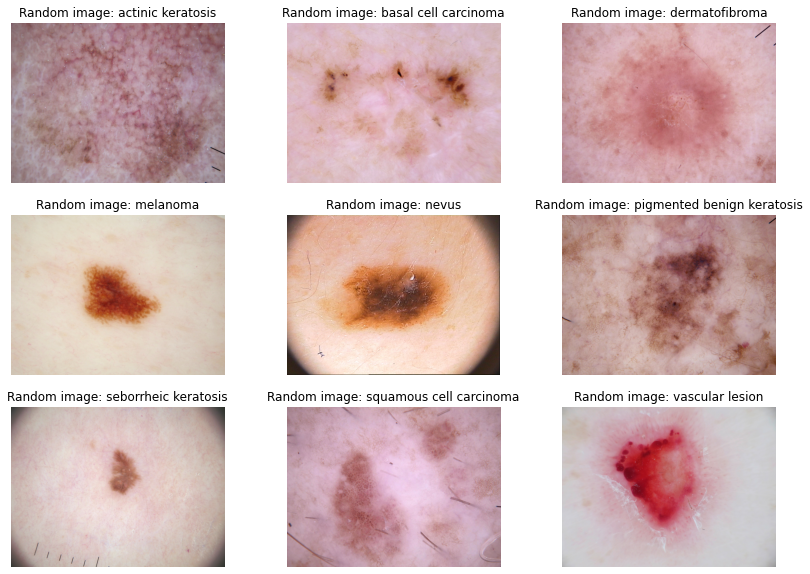

In [10]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(14, 10))
for ix, cls in enumerate(class_names):
  train_cls_dir_path = data_dir_train.joinpath(cls)
  rand_img_path = np.random.choice(list(train_cls_dir_path.glob('*.jpg')))
  im = plt.imread(rand_img_path)
  ax = plt.subplot(3, 3, ix+1)
  plt.title(f'Random image: {cls}')
  plt.axis('off')
  plt.imshow(im)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [12]:
### Defining various layers 
preprocessing_layers = [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3))
]
core_layers = [
    tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2, 2)),
    tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2, 2)),
    tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2, 2))
]
dense_layers = [
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(9, activation='softmax')
]

#tf.random.set_seed(42)
# Defining the Sequential model
model = tf.keras.Sequential(
    preprocessing_layers +
    core_layers +
    dense_layers
)

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [13]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [14]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 32)        9

### Train the model

In [15]:
# Checking if GPU device is present to perfom model training
tf.test.gpu_device_name()

'/device:GPU:0'

In [16]:
# Training the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 285s 1s/step - loss: 2.0855 - accuracy: 0.2065 - val_loss: 2.0418 - val_accuracy: 0.1499
Epoch 2/20
56/56 [==============================] - 1s 23ms/step - loss: 1.9636 - accuracy: 0.2556 - val_loss: 1.8900 - val_accuracy: 0.2864
Epoch 3/20
56/56 [==============================] - 1s 22ms/step - loss: 1.7880 - accuracy: 0.3599 - val_loss: 1.5882 - val_accuracy: 0.4609
Epoch 4/20
56/56 [==============================] - 1s 22ms/step - loss: 1.5316 - accuracy: 0.4559 - val_loss: 1.4483 - val_accuracy: 0.4989
Epoch 5/20
56/56 [==============================] - 1s 22ms/step - loss: 1.4243 - accuracy: 0.4939 - val_loss: 1.3853 - val_accuracy: 0.5213
Epoch 6/20
56/56 [==============================] - 1s 22ms/step - loss: 1.3299 - accuracy: 0.5385 - val_loss: 1.3908 - val_accuracy: 0.4989
Epoch 7/20
56/56 [==============================] - 1s 22ms/step - loss: 1.3006 - accuracy: 0.5485 - val_loss: 1.3781 - val_accuracy: 0.5235
Epoch 8/20
56

### Visualizing training results

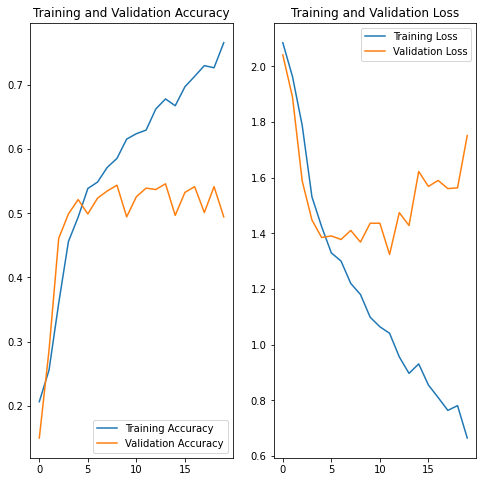

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

- From the above plot we clearly see that training accuracy increased with increase in number of epochs. However no increase in validation accuracy is observed after initial few number of epochs.
- The training accuracy increased to 76% after 20 epochs and validation accuracy fluctuated between 49% and 55% only.
- Even the validation loss decreased with increase in fewer number of epochs and then increased afterwards. Hence, the model is **overfitted**.

In [18]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here

# Defining data augmentation layers
data_augmentation_layers = [
    tf.keras.layers.RandomFlip("horizontal"), 
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1)
]

Original image


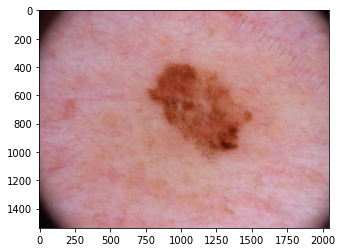

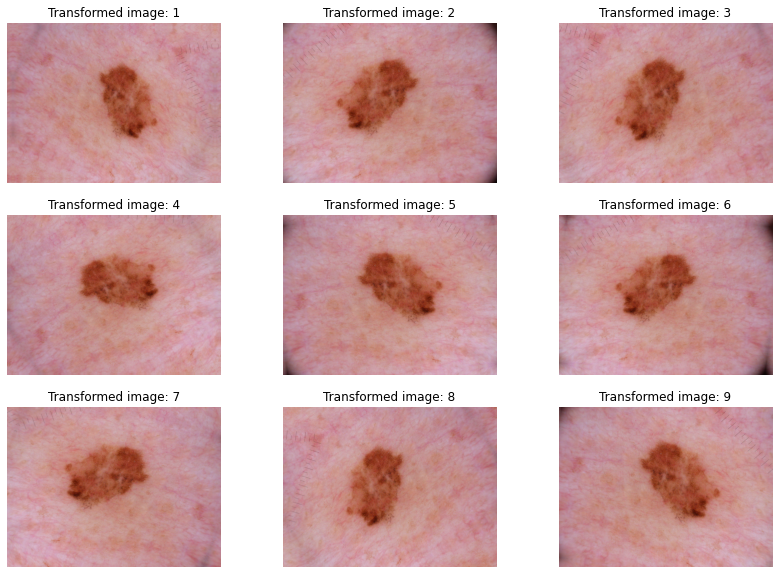

In [19]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
# Visualizing a randomly choosen image and 9 transformed images of it
data_augumetaion = tf.keras.Sequential(data_augmentation_layers)
train_cls_dir_path = data_dir_train.joinpath('melanoma')
rand_img_path = np.random.choice(list(train_cls_dir_path.glob('*.jpg')))
img = plt.imread(rand_img_path)
print('Original image')
plt.imshow(img)
plt.figure(figsize=(14, 10))
for ix in range(9):
  #img = plt.imread(rand_img_path)
  augmented_img = data_augumetaion(img)
  ax = plt.subplot(3, 3, ix+1)
  plt.title(f'Transformed image: {ix+1}')
  plt.axis('off')
  plt.imshow(augmented_img.numpy().astype('uint8'))

### Todo:
### Create the model, compile and train the model


In [20]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [21]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

# Defining the model 
#tf.random.set_seed(42)
model = tf.keras.Sequential(
    data_augmentation_layers +
    preprocessing_layers +
    core_layers +
    [tf.keras.layers.Dropout(0.2)] +
    dense_layers 
)

### Compiling the model

In [22]:
## Your code goes here
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

### Training the model

In [24]:
## Your code goes here, note: train your model for 20 epochs
# Training the model
epochs = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 3s 41ms/step - loss: 1.3054 - accuracy: 0.5491 - val_loss: 1.5067 - val_accuracy: 0.5213
Epoch 2/20
56/56 [==============================] - 2s 38ms/step - loss: 1.1884 - accuracy: 0.5636 - val_loss: 1.2853 - val_accuracy: 0.5727
Epoch 3/20
56/56 [==============================] - 2s 38ms/step - loss: 1.1865 - accuracy: 0.5731 - val_loss: 1.6192 - val_accuracy: 0.5235
Epoch 4/20
56/56 [==============================] - 2s 39ms/step - loss: 1.2234 - accuracy: 0.5586 - val_loss: 1.3171 - val_accuracy: 0.5280
Epoch 5/20
56/56 [==============================] - 2s 38ms/step - loss: 1.1254 - accuracy: 0.5999 - val_loss: 1.2269 - val_accuracy: 0.5951
Epoch 6/20
56/56 [==============================] - 2s 38ms/step - loss: 1.1307 - accuracy: 0.5993 - val_loss: 1.2314 - val_accuracy: 0.5660
Epoch 7/20
56/56 [==============================] - 2s 38ms/step - loss: 1.0862 - accuracy: 0.6094 - val_loss: 1.2717 - val_accuracy: 0.5570
Epoch 8/20
56

### Visualizing the results

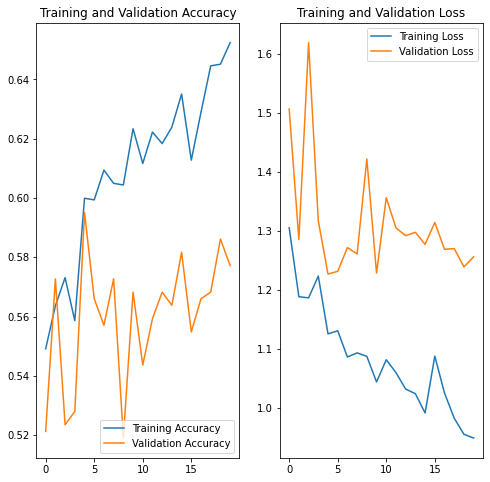

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

- To reduce overfitting, added a data augumentation layer and a dropout layer.
-The gap between train and validation accuracies has decreased when compared to previous model and thus reduced overfitting.
- However, After 20 epochs of training with new layers, we observed that training accuracy increased to 65% only and validation accuracy to 57% only, with increase in number of epochs.
- This indicates the model needs to learn more features to increase the training and validation accuracies and appears **underfitted**.


#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

                        class  count  samples_perct
0           actinic keratosis    114       5.091559
1        basal cell carcinoma    376      16.793211
2              dermatofibroma     95       4.242966
3                    melanoma    438      19.562305
4                       nevus    357      15.944618
5  pigmented benign keratosis    462      20.634212
6        seborrheic keratosis     77       3.439035
7     squamous cell carcinoma    181       8.083966
8             vascular lesion    139       6.208129


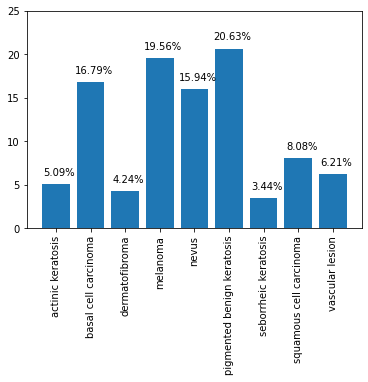

In [26]:
## Your code goes here.
# Determing images distribution of various classes
class_df = pd.DataFrame()
for ix, cls in enumerate(class_names):
  train_cls_dir_path = data_dir_train.joinpath(cls)
  size = len(list(train_cls_dir_path.glob('*.jpg')))
  class_df = pd.concat([class_df, pd.DataFrame([{'class':cls, 'count':size}])], ignore_index=True)

tot_samples = class_df['count'].sum()
class_df['samples_perct'] = (class_df['count']/tot_samples)*100
print(class_df)
fig, ax = plt.subplots()
ax.bar(class_df.index, class_df['samples_perct'])
ax.set_ylim(0, 25)
vals = class_df['samples_perct'].round(2).apply(lambda x: f'{x}%').to_list()
for i in range(len(vals)):
  ax.text(class_df.index[i]+0.1, class_df['samples_perct'][i]+1, vals[i], ha='center' )
ax.set_xticks(class_df.index)
ax.set_xticklabels(labels=class_df['class'], rotation=90)
plt.show()

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
- From above bar plot we can see that class **seborrheic keratosis** is having least number of samples, which constitues to **3.44 percentage** of overall images. 
#### - Which classes dominate the data in terms proportionate number of samples?
- Classess **pigmented benign keratosis** , **melanoma**, **basal cell carcinoma** and **nevus** dominate the data with 20.63%, 19.56%, 16.79% and 15.94% respectively.
- These four classess all together constitue to around 73% of overall images.

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [28]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [29]:
path_to_training_dataset=data_dir_train
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset.joinpath(i))
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Learnings/Case_Studies/Melanoma_Detection/SkinCancerDataSet/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9B9021F3A0>: 100%|██████████| 500/500 [00:21<00:00, 22.80 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Learnings/Case_Studies/Melanoma_Detection/SkinCancerDataSet/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9B900B7220>: 100%|██████████| 500/500 [00:23<00:00, 21.49 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Learnings/Case_Studies/Melanoma_Detection/SkinCancerDataSet/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9B36084F10>: 100%|██████████| 500/500 [00:18<00:00, 27.35 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Learnings/Case_Studies/Melanoma_Detection/SkinCancerDataSet/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F9B90116220>: 100%|██████████| 500/500 [01:19<00:00,  6.27 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Learnings/Case_Studies/Melanoma_Detection/SkinCancerDataSet/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7F9B361B6F40>: 100%|██████████| 500/500 [01:20<00:00,  6.22 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Learnings/Case_Studies/Melanoma_Detection/SkinCancerDataSet/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9B361EC6D0>: 100%|██████████| 500/500 [00:18<00:00, 27.04 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Learnings/Case_Studies/Melanoma_Detection/SkinCancerDataSet/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F9B901160D0>: 100%|██████████| 500/500 [00:40<00:00, 12.22 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Learnings/Case_Studies/Melanoma_Detection/SkinCancerDataSet/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9B36515D00>: 100%|██████████| 500/500 [00:18<00:00, 27.20 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Learnings/Case_Studies/Melanoma_Detection/SkinCancerDataSet/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9B362831C0>: 100%|██████████| 500/500 [00:18<00:00, 27.34 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [30]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [31]:
from glob import glob

In [32]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/drive/MyDrive/Learnings/Case_Studies/Melanoma_Detection/SkinCancerDataSet/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025247.jpg_0d2d8563-7c44-4d7a-bf36-bc7e08075df1.jpg',
 '/content/drive/MyDrive/Learnings/Case_Studies/Melanoma_Detection/SkinCancerDataSet/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025539.jpg_9c09b8ce-5a52-4805-95ec-a73a2960df4d.jpg',
 '/content/drive/MyDrive/Learnings/Case_Studies/Melanoma_Detection/SkinCancerDataSet/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027678.jpg_19e8072b-56a4-4b84-9f86-989e2254153d.jpg',
 '/content/drive/MyDrive/Learnings/Case_Studies/Melanoma_Detection/SkinCancerDataSet/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029268.jpg_91a18c52-ac4e-4130-a076-f4bb9c823388.jpg',
 '/content/drive/MyDrive/Learnings/Case_Studies/Melanoma_Detection/SkinCancerDataSet/Train/squamous cell carcinoma/output/squamous cell carc

In [33]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carc

In [34]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [35]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
#new_df = original_df.append(df2)

In [36]:
df2['Label'].value_counts()

squamous cell carcinoma       500
actinic keratosis             500
pigmented benign keratosis    500
melanoma                      500
dermatofibroma                500
basal cell carcinoma          500
vascular lesion               500
nevus                         500
seborrheic keratosis          500
Name: Label, dtype: int64

In [37]:
#new_df['Label'].value_counts()

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [38]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [39]:
# Displaying path to directory with training data + dta created using augmentor
train_path

'/content/drive/MyDrive/Learnings/Case_Studies/Melanoma_Detection/SkinCancerDataSet/Train'

In [40]:
#data_dir_train="path to directory with training data + data created using augmentor"
data_dir_train=pathlib.Path(train_path)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [41]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [42]:
## your code goes here

model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2, 2)),
    tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2, 2)),
    tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(9, activation='softmax')
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [43]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [45]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 40s 221ms/step - loss: 1.7182 - accuracy: 0.4026 - val_loss: 2.5205 - val_accuracy: 0.1240
Epoch 2/30
169/169 [==============================] - 30s 174ms/step - loss: 1.2974 - accuracy: 0.5339 - val_loss: 2.9740 - val_accuracy: 0.1500
Epoch 3/30
169/169 [==============================] - 33s 188ms/step - loss: 1.0802 - accuracy: 0.6120 - val_loss: 2.1655 - val_accuracy: 0.3526
Epoch 4/30
169/169 [==============================] - 30s 174ms/step - loss: 1.0051 - accuracy: 0.6419 - val_loss: 2.2234 - val_accuracy: 0.3653
Epoch 5/30
169/169 [==============================] - 30s 174ms/step - loss: 0.8271 - accuracy: 0.7086 - val_loss: 1.3340 - val_accuracy: 0.5516
Epoch 6/30
169/169 [==============================] - 30s 172ms/step - loss: 0.6772 - accuracy: 0.7622 - val_loss: 1.3021 - val_accuracy: 0.5917
Epoch 7/30
169/169 [==============================] - 31s 176ms/step - loss: 0.5712 - accuracy: 0.8030 - val_loss: 2.3268 - val_ac

#### **Todo:**  Visualize the model results

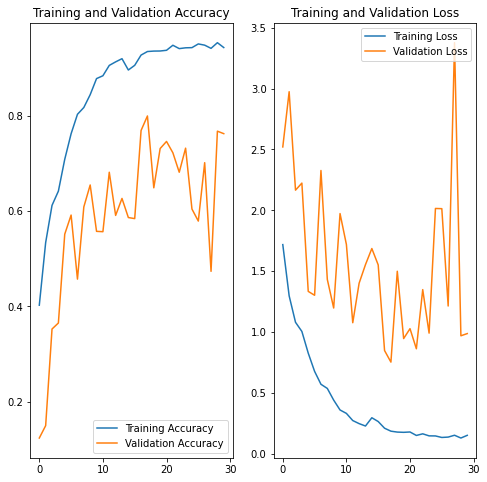

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



- After 30 epochs, the training accuracy increased to 94% and validation accuracy to 76%.
- In addition, training loss reduced to 0.15 and validation loss to 0.98 .
- Class rebalancing has helped in eliminating underfitting by extracting more features from resulted augumented image samples.
- However, the gap between training and validation accuracies is considerable and needs to be addressed.  
- By training with more image samples and increase in feature maps of CNN layers, the problem of overfitting can be addressed 